In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt

data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')

matrix_data = data['data']

print(f"\nType of 'data':", type(matrix_data))
print(f"Shape of 'data':", matrix_data.shape)


Type of 'data': <class 'numpy.ndarray'>
Shape of 'data': (16, 604700)


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 35.4238
Epoch 2/10
1/1 [==============================] - 1s 572ms/step - loss: 34.7007
Epoch 3/10
1/1 [==============================] - 1s 580ms/step - loss: 34.0858
Epoch 4/10
1/1 [==============================] - 1s 574ms/step - loss: 33.5766
Epoch 5/10
1/1 [==============================] - 1s 580ms/step - loss: 33.1688
Epoch 6/10
1/1 [==============================] - 1s 581ms/step - loss: 32.8566
Epoch 7/10
1/1 [==============================] - 1s 584ms/step - loss: 32.6321
Epoch 8/10
1/1 [==============================] - 1s 585ms/step - loss: 32.4851
Epoch 9/10
1/1 [==============================] - 1s 588ms/step - loss: 32.4031
Epoch 10/10
1/1 [==============================] - 1s 605ms/step - loss: 32.3714


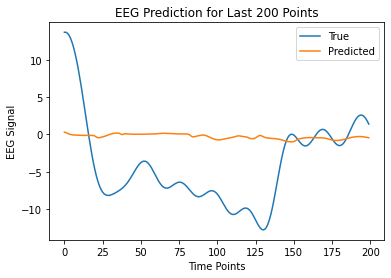

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Attention, Concatenate
import scipy.io as scio
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']

# 提取每个通道的前5000个点
matrix_data = matrix_data[:, :5000]

# 定义训练和预测数据
X_train = matrix_data[:, :4800]  # 前4800个点作为训练输入
y_true = matrix_data[:, 4800:]   # 后200个点作为真实值进行对比

# 将数据调整为模型输入格式: (samples, time_steps, features)
X_train = np.expand_dims(X_train.T, axis=0)  # 转置并扩展维度
y_true = np.expand_dims(y_true.T, axis=0)

# 构建带注意力机制的GRU模型
class AttentionGRUModel(Model):
    def __init__(self):
        super(AttentionGRUModel, self).__init__()
        self.gru = GRU(64, return_sequences=True)
        self.attention = Attention()
        self.dense = Dense(1)

    def call(self, inputs):
        gru_output = self.gru(inputs)
        attention_output = self.attention([gru_output, gru_output])
        output = self.dense(attention_output)
        return output

# 初始化模型
model = AttentionGRUModel()

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
model.fit(X_train, X_train, epochs=10, batch_size=1, verbose=1)

# 进行预测
y_pred = model.predict(X_train)[:, -200:, 0]  # 只保留最后200个点的预测结果

# 可视化真实值和预测值
plt.plot(y_true[0, :, 0], label="True")
plt.plot(y_pred[0], label="Predicted")
plt.xlabel("Time Points")
plt.ylabel("EEG Signal")
plt.legend()
plt.title("EEG Prediction for Last 200 Points")
plt.show()


In [10]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from scipy.signal import welch

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 数据划分为训练集和测试集，并截断至相同长度
X = np.expand_dims(matrix_data, axis=-1)  # 形状 (16, 5000, 1)
X = np.expand_dims(X, axis=0)  # 扩展为 (1, 16, 5000, 1)
train_X, test_X = X[:, :, -200:, :], X[:, :, -200:, :]  # 使用最后200个点作为训练和测试输入

# 模拟目标值（回归任务的真实值）
y_train = np.random.randn(1, 1)  # 示例目标值
y_test = np.random.randn(1, 1)

# 定义 EEGNet 模型结构（回归任务）
def EEGNet_regression(Chans=16, Samples=200, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = tf.keras.layers.Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    ##################################################################
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = tf.keras.layers.Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    ##################################################################
    flatten = Flatten(name='flatten')(block2)

    dense = Dense(1, name='dense', activation='linear')(flatten)

    return Model(inputs=input1, outputs=dense)

# 初始化和编译模型
model = EEGNet_regression(Chans=16, Samples=200)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit(train_X, y_train, epochs=20, batch_size=1, verbose=1)

# 预测测试集
predicted_y = model.predict(test_X)

# 计算频谱相似度（使用 Welch 方法），根据信号长度动态调整 nperseg
def calculate_spectral_similarity(true_signal, predicted_signal):
    min_length = min(len(true_signal), len(predicted_signal))
    nperseg = min(50, min_length)  # 动态调整 nperseg
    f_true, Pxx_true = welch(true_signal, nperseg=nperseg)
    f_pred, Pxx_pred = welch(predicted_signal, nperseg=nperseg)
    # 计算余弦相似度
    similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
    return similarity

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(y_test, predicted_y)
print("Spectral Similarity:", spectral_similarity)

# 打印结果
print("Mean Squared Error:", mean_squared_error(y_test, predicted_y))


Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0096 - mean_absolute_error: 0.0979
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 2.2483 - mean_absolute_error: 1.4994
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 3.3694 - mean_absolute_error: 1.8356
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 1.4064 - mean_absolute_error: 1.1859
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 2.2584 - mean_absolute_error: 1.5028
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.2272 - mean_absolute_error: 0.4766
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0728
Epoch 8/20
1/1 [==============================] - 0s 13ms/step - loss: 0.0054 - mean_absolute_error: 0.0732
Epoch 9/20
1/1 [==============================] - 0s 13ms/step - loss: 0.0119 - mean_absolute_error: 0.1092
Epoch 10/20
1/1 [=============

C:\Users\Brilliant\AppData\Local\Temp\ipykernel_17876\2199604865.py:66: RuntimeWarning: invalid value encountered in divide
  similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))


In [11]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from scipy.signal import welch

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 数据划分为训练集和测试集，并截断至相同长度
X = np.expand_dims(matrix_data, axis=-1)  # 形状 (16, 5000, 1)
X = np.expand_dims(X, axis=0)  # 扩展为 (1, 16, 5000, 1)
train_X, test_X = X[:, :, -200:, :], X[:, :, -200:, :]  # 使用最后200个点作为训练和测试输入

# 模拟目标值（回归任务的真实值）
y_train = np.random.randn(1, 1)  # 示例目标值
y_test = np.random.randn(1, 1)

# 定义 EEGNet 模型结构（回归任务）
def EEGNet_regression(Chans=16, Samples=200, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = tf.keras.layers.Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    ##################################################################
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = tf.keras.layers.Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    ##################################################################
    flatten = Flatten(name='flatten')(block2)

    dense = Dense(1, name='dense', activation='linear')(flatten)

    return Model(inputs=input1, outputs=dense)

# 初始化和编译模型
model = EEGNet_regression(Chans=16, Samples=200)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit(train_X, y_train, epochs=20, batch_size=1, verbose=1)

# 预测测试集
predicted_y = model.predict(test_X)

# 计算频谱相似度（使用 Welch 方法），根据信号长度动态调整 nperseg
def calculate_spectral_similarity(true_signal, predicted_signal):
    min_length = min(len(true_signal), len(predicted_signal))
    nperseg = min(50, min_length)  # 动态调整 nperseg
    f_true, Pxx_true = welch(true_signal, nperseg=nperseg)
    f_pred, Pxx_pred = welch(predicted_signal, nperseg=nperseg)
    
    # 检查 Pxx_true 和 Pxx_pred 是否全为零
    if np.all(Pxx_true == 0) or np.all(Pxx_pred == 0):
        print("Warning: One of the power spectra is all zeros, cannot compute spectral similarity.")
        return np.nan
    
    # 计算余弦相似度
    similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
    return similarity

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(y_test, predicted_y)
print("Spectral Similarity:", spectral_similarity)

# 打印结果
print("Mean Squared Error:", mean_squared_error(y_test, predicted_y))


Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.3829 - mean_absolute_error: 0.6188
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_absolute_error: 0.0561
Epoch 3/20
1/1 [==============================] - 0s 14ms/step - loss: 0.1132 - mean_absolute_error: 0.3365
Epoch 4/20
1/1 [==============================] - 0s 13ms/step - loss: 0.7937 - mean_absolute_error: 0.8909
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2430 - mean_absolute_error: 0.4930
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0353
Epoch 7/20
1/1 [==============================] - 0s 14ms/step - loss: 0.0160 - mean_absolute_error: 0.1263
Epoch 8/20
1/1 [==============================] - 0s 15ms/step - loss: 0.7315 - mean_absolute_error: 0.8553
Epoch 9/20
1/1 [==============================] - 0s 16ms/step - loss: 1.9381 - mean_absolute_error: 1.3922
Epoch 10/20
1/1 [=============

Epoch 1/20
1/1 [==============================] - 1s 985ms/step - loss: 5.7511 - mean_absolute_error: 2.3981
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 0.5628 - mean_absolute_error: 0.7502
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2997 - mean_absolute_error: 0.5475
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5803 - mean_absolute_error: 0.7618
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 1.3679 - mean_absolute_error: 1.1696
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3280 - mean_absolute_error: 0.5727
Epoch 7/20
1/1 [==============================] - 0s 15ms/step - loss: 1.8466 - mean_absolute_error: 1.3589
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.3747 - mean_absolute_error: 0.6121
Epoch 9/20
1/1 [==============================] - 0s 14ms/step - loss: 1.6116 - mean_absolute_error: 1.2695
Epoch 10/20
1/1 [==========

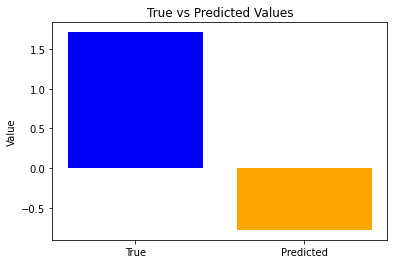

In [13]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 数据划分为训练集和测试集，并截断至相同长度
X = np.expand_dims(matrix_data, axis=-1)  # 形状 (16, 5000, 1)
X = np.expand_dims(X, axis=0)  # 扩展为 (1, 16, 5000, 1)
train_X, test_X = X[:, :, -200:, :], X[:, :, -200:, :]  # 使用最后200个点作为训练和测试输入

# 模拟目标值（回归任务的真实值）
y_train = np.random.randn(1)  # 示例目标值
y_test = np.random.randn(1)

# 定义 EEGNet 模型结构（回归任务）
def EEGNet_regression(Chans=16, Samples=200, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = tf.keras.layers.Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    ##################################################################
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = tf.keras.layers.Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    ##################################################################
    flatten = Flatten(name='flatten')(block2)

    dense = Dense(1, name='dense', activation='linear')(flatten)

    return Model(inputs=input1, outputs=dense)

# 初始化和编译模型
model = EEGNet_regression(Chans=16, Samples=200)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit(train_X, y_train, epochs=20, batch_size=1, verbose=1)

# 预测测试集
predicted_y = model.predict(test_X)

# 打印结果
print("True Value:", y_test)
print("Predicted Value:", predicted_y[0][0])
print("Mean Squared Error:", mean_squared_error([y_test], predicted_y))

# 绘制预测值与真实值
plt.figure(figsize=(6, 4))
plt.bar(['True', 'Predicted'], [y_test[0], predicted_y[0][0]], color=['blue', 'orange'])
plt.ylabel("Value")
plt.title("True vs Predicted Values")
plt.show()


Epoch 1/20
1/1 [==============================] - 0s 449ms/step - loss: 28.9341 - mean_absolute_error: 3.8695
Epoch 2/20
1/1 [==============================] - 0s 52ms/step - loss: 28.9071 - mean_absolute_error: 3.8661
Epoch 3/20
1/1 [==============================] - 0s 51ms/step - loss: 28.8802 - mean_absolute_error: 3.8627
Epoch 4/20
1/1 [==============================] - 0s 51ms/step - loss: 28.8534 - mean_absolute_error: 3.8593
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 28.8265 - mean_absolute_error: 3.8559
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 28.8026 - mean_absolute_error: 3.8528
Epoch 7/20
1/1 [==============================] - 0s 50ms/step - loss: 28.7714 - mean_absolute_error: 3.8488
Epoch 8/20
1/1 [==============================] - 0s 61ms/step - loss: 28.7395 - mean_absolute_error: 3.8447
Epoch 9/20
1/1 [==============================] - 0s 51ms/step - loss: 28.7152 - mean_absolute_error: 3.8416
Epoch 10/20
1/1 [=

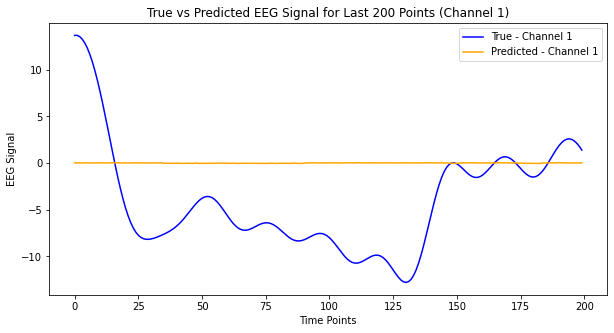

In [17]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from scipy.signal import welch
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 数据划分为训练集和测试集
X = np.expand_dims(matrix_data, axis=-1)  # 形状 (16, 5000, 1)
X = np.expand_dims(X, axis=0)  # 扩展为 (1, 16, 5000, 1)
train_X, test_X = X[:, :, :4800, :], X[:, :, 4800:, :]  # 这里保持了不同长度的输入

# 将 y_train 和 y_test 调整为最后 200 个点
y_train = matrix_data[:, 4600:4800]  # 训练集目标序列
y_test = matrix_data[:, 4800:]       # 测试集目标序列

# 确保目标数据形状符合模型输出
y_train = y_train.reshape(1, 16, 200)
y_test = y_test.reshape(1, 16, 200)

# 定义可以接受任意长度输入的 EEGNet 模型结构（回归任务）
def EEGNet_flexible(Chans=16, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    input1 = Input(shape=(Chans, None, 1))  # 时间步数设置为 None，表示可变长度

    ##################################################################
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = tf.keras.layers.Activation('elu')(block1)
    block1 = Dropout(dropoutRate)(block1)

    ##################################################################
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = tf.keras.layers.Activation('elu')(block2)
    block2 = Dropout(dropoutRate)(block2)

    ##################################################################
    # 使用全局平均池化将可变长度的时间步数据聚合到一个固定大小的特征向量
    global_pool = GlobalAveragePooling2D()(block2)

    dense = Dense(16 * 200, name='dense', activation='linear')(global_pool)  # 输出16通道*200个点的序列
    output = tf.keras.layers.Reshape((16, 200))(dense)  # 重塑为 (16, 200)

    return Model(inputs=input1, outputs=output)

# 初始化和编译模型
model = EEGNet_flexible(Chans=16)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit(train_X, y_train, epochs=20, batch_size=1, verbose=1)

# 预测测试集（这里测试输入可以是任意长度）
predicted_y = model.predict(test_X)

# 计算频谱相似度（使用 Welch 方法），这里对每个通道分别计算相似度
def calculate_spectral_similarity(true_signal, predicted_signal):
    similarities = []
    for ch in range(true_signal.shape[0]):  # 针对每个通道计算
        f_true, Pxx_true = welch(true_signal[ch], nperseg=50)
        f_pred, Pxx_pred = welch(predicted_signal[ch], nperseg=50)
        
        # 检查 Pxx_true 和 Pxx_pred 是否全为零
        if np.all(Pxx_true == 0) or np.all(Pxx_pred == 0):
            similarities.append(np.nan)
        else:
            # 计算余弦相似度
            similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
            similarities.append(similarity)
    return np.nanmean(similarities)  # 返回平均相似度

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(y_test[0], predicted_y[0])
print("Spectral Similarity:", spectral_similarity)

# 打印结果
print("Mean Squared Error:", mean_squared_error(y_test.flatten(), predicted_y.flatten()))

# 绘制预测值与真实值
plt.figure(figsize=(10, 5))
plt.plot(y_test[0, 0, :], label="True - Channel 1", color="blue")  # 仅绘制第一个通道的数据
plt.plot(predicted_y[0, 0, :], label="Predicted - Channel 1", color="orange")
plt.xlabel("Time Points")
plt.ylabel("EEG Signal")
plt.title("True vs Predicted EEG Signal for Last 200 Points (Channel 1)")
plt.legend()
plt.show()


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 51.2568 - mean_absolute_error: 6.0141
Epoch 2/20
1/1 [==============================] - 1s 543ms/step - loss: 45.7960 - mean_absolute_error: 5.6280
Epoch 3/20
1/1 [==============================] - 1s 743ms/step - loss: 41.2414 - mean_absolute_error: 5.3231
Epoch 4/20
1/1 [==============================] - 1s 824ms/step - loss: 37.6248 - mean_absolute_error: 5.1058
Epoch 5/20
1/1 [==============================] - 1s 787ms/step - loss: 34.8681 - mean_absolute_error: 4.9487
Epoch 6/20
1/1 [==============================] - 1s 812ms/step - loss: 32.9302 - mean_absolute_error: 4.8099
Epoch 7/20
1/1 [==============================] - 1s 789ms/step - loss: 31.7306 - mean_absolute_error: 4.6963
Epoch 8/20
1/1 [==============================] - 1s 814ms/step - loss: 31.0699 - mean_absolute_error: 4.6053
Epoch 9/20
1/1 [==============================] - 1s 809ms/step - loss: 30.7590 - mean_absolute_error: 4.5427
Epoch 10/20
1

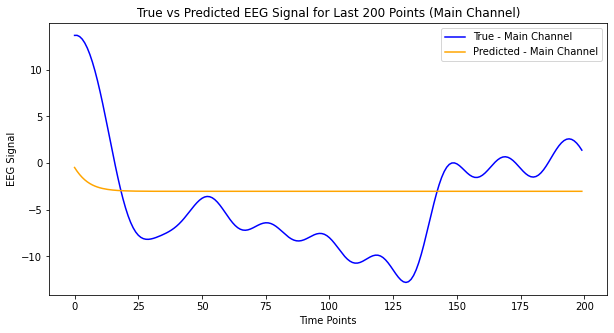

In [19]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error
from scipy.signal import welch
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 主通道为第一个通道，辅助通道选择第2到第5个通道
main_channel = matrix_data[0, :]      # 主通道
aux_channels = matrix_data[1:5, :]    # 选择4个辅助通道

# 使用前4800个点作为训练，预测最后200个点
train_main = main_channel[:4800].reshape(1, 4800, 1)
test_main = main_channel[4800:].reshape(1, 200, 1)
train_aux = aux_channels[:, :4800].transpose((1, 0)).reshape(1, 4800, 4)  # 4个辅助通道
test_aux = aux_channels[:, 4800:].transpose((1, 0)).reshape(1, 200, 4)

# 定义可以接受任意长度输入并预测未来200个时间步的模型
def build_seq2seq_model():
    # 主通道输入
    main_input = Input(shape=(None, 1), name="main_input")  # None 表示任意长度输入
    # 辅助通道输入
    aux_input = Input(shape=(None, 4), name="aux_input")

    # 主通道和辅助通道分别通过 LSTM 进行编码
    main_encoded = LSTM(64, return_sequences=False)(main_input)
    aux_encoded = LSTM(64, return_sequences=False)(aux_input)

    # 合并主通道和辅助通道的编码结果
    merged = Concatenate()([main_encoded, aux_encoded])

    # 重复编码结果200次，以便用于解码
    repeated_context = RepeatVector(200)(merged)

    # 解码器LSTM用于预测未来200个时间步
    decoder_lstm = LSTM(64, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(1))(decoder_lstm)  # 输出未来200步的预测序列

    # 构建模型
    model = Model(inputs=[main_input, aux_input], outputs=output)
    return model

# 初始化和编译模型
model = build_seq2seq_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit([train_main, train_aux], test_main.reshape(1, 200, 1), epochs=20, batch_size=1, verbose=1)

# 预测测试集未来200个时间步
predicted_y = model.predict([test_main, test_aux])

# 计算频谱相似度
def calculate_spectral_similarity(true_signal, predicted_signal):
    f_true, Pxx_true = welch(true_signal, nperseg=50)
    f_pred, Pxx_pred = welch(predicted_signal, nperseg=50)
    
    # 检查 Pxx_true 和 Pxx_pred 是否全为零
    if np.all(Pxx_true == 0) or np.all(Pxx_pred == 0):
        return np.nan
    
    # 计算余弦相似度
    similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
    return similarity

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(test_main.flatten(), predicted_y.flatten())
print("Spectral Similarity:", spectral_similarity)

# 打印均方误差
print("Mean Squared Error:", mean_squared_error(test_main.flatten(), predicted_y.flatten()))

# 绘制预测值与真实值
plt.figure(figsize=(10, 5))
plt.plot(test_main.flatten(), label="True - Main Channel", color="blue")
plt.plot(predicted_y.flatten(), label="Predicted - Main Channel", color="orange")
plt.xlabel("Time Points")
plt.ylabel("EEG Signal")
plt.title("True vs Predicted EEG Signal for Last 200 Points (Main Channel)")
plt.legend()
plt.show()


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 48.5298 - mean_absolute_error: 5.8135
Epoch 2/20
1/1 [==============================] - 1s 523ms/step - loss: 43.0448 - mean_absolute_error: 5.4399
Epoch 3/20
1/1 [==============================] - 1s 590ms/step - loss: 38.9013 - mean_absolute_error: 5.1728
Epoch 4/20
1/1 [==============================] - 1s 775ms/step - loss: 35.9388 - mean_absolute_error: 5.0123
Epoch 5/20
1/1 [==============================] - 1s 778ms/step - loss: 33.8994 - mean_absolute_error: 4.8792
Epoch 6/20
1/1 [==============================] - 1s 789ms/step - loss: 32.5416 - mean_absolute_error: 4.7677
Epoch 7/20
1/1 [==============================] - 1s 779ms/step - loss: 31.6798 - mean_absolute_error: 4.6732
Epoch 8/20
1/1 [==============================] - 1s 773ms/step - loss: 31.1821 - mean_absolute_error: 4.5954
Epoch 9/20
1/1 [==============================] - 1s 825ms/step - loss: 30.9476 - mean_absolute_error: 4.5415
Epoch 10/20
1

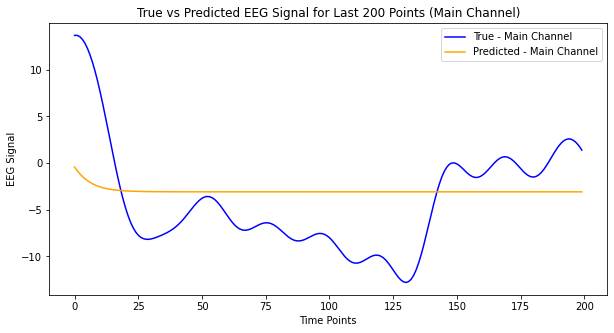

In [20]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, RepeatVector, TimeDistributed, Attention, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from scipy.signal import welch
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 主通道为第一个通道，辅助通道选择第2到第5个通道
main_channel = matrix_data[0, :]      # 主通道
aux_channels = matrix_data[1:5, :]    # 选择4个辅助通道

# 使用前4800个点作为训练，预测最后200个点
train_main = main_channel[:4800].reshape(1, 4800, 1)
test_main = main_channel[4800:].reshape(1, 200, 1)
train_aux = aux_channels[:, :4800].transpose((1, 0)).reshape(1, 4800, 4)  # 4个辅助通道
test_aux = aux_channels[:, 4800:].transpose((1, 0)).reshape(1, 200, 4)

# 定义改进的模型，可以接受任意长度输入并预测未来200个时间步
def build_improved_seq2seq_model():
    # 主通道输入
    main_input = Input(shape=(None, 1), name="main_input")  # None 表示任意长度输入
    # 辅助通道输入
    aux_input = Input(shape=(None, 4), name="aux_input")

    # 主通道卷积特征提取
    main_conv = Conv1D(32, kernel_size=3, activation='relu')(main_input)
    main_flat = Flatten()(main_conv)
    main_encoded = LSTM(64, return_sequences=False)(main_input)

    # 辅助通道卷积特征提取
    aux_conv = Conv1D(32, kernel_size=3, activation='relu')(aux_input)
    aux_flat = Flatten()(aux_conv)
    aux_encoded = LSTM(64, return_sequences=False)(aux_input)

    # 合并主通道和辅助通道的编码结果
    merged = Concatenate()([main_encoded, aux_encoded])

    # 重复编码结果200次，以便用于解码
    repeated_context = RepeatVector(200)(merged)

    # 解码器LSTM用于预测未来200个时间步
    decoder_lstm = LSTM(64, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(1))(decoder_lstm)  # 输出未来200步的预测序列

    # 构建模型
    model = Model(inputs=[main_input, aux_input], outputs=output)
    return model

# 初始化和编译模型
model = build_improved_seq2seq_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit([train_main, train_aux], test_main.reshape(1, 200, 1), epochs=20, batch_size=1, verbose=1)

# 预测测试集未来200个时间步
predicted_y = model.predict([test_main, test_aux])

# 计算频谱相似度
def calculate_spectral_similarity(true_signal, predicted_signal):
    f_true, Pxx_true = welch(true_signal, nperseg=50)
    f_pred, Pxx_pred = welch(predicted_signal, nperseg=50)
    
    # 检查 Pxx_true 和 Pxx_pred 是否全为零
    if np.all(Pxx_true == 0) or np.all(Pxx_pred == 0):
        return np.nan
    
    # 计算余弦相似度
    similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
    return similarity

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(test_main.flatten(), predicted_y.flatten())
print("Spectral Similarity:", spectral_similarity)

# 打印均方误差
print("Mean Squared Error:", mean_squared_error(test_main.flatten(), predicted_y.flatten()))

# 绘制预测值与真实值
plt.figure(figsize=(10, 5))
plt.plot(test_main.flatten(), label="True - Main Channel", color="blue")
plt.plot(predicted_y.flatten(), label="Predicted - Main Channel", color="orange")
plt.xlabel("Time Points")
plt.ylabel("EEG Signal")
plt.title("True vs Predicted EEG Signal for Last 200 Points (Main Channel)")
plt.legend()
plt.show()


Epoch 1/20
1/1 [==============================] - 8s 8s/step - loss: 44.5520 - mean_absolute_error: 5.5373
Epoch 2/20
1/1 [==============================] - 5s 5s/step - loss: 37.7617 - mean_absolute_error: 5.1058
Epoch 3/20
1/1 [==============================] - 5s 5s/step - loss: 33.7180 - mean_absolute_error: 4.8406
Epoch 4/20
1/1 [==============================] - 5s 5s/step - loss: 31.8062 - mean_absolute_error: 4.6252
Epoch 5/20
1/1 [==============================] - 5s 5s/step - loss: 31.3723 - mean_absolute_error: 4.5009
Epoch 6/20
1/1 [==============================] - 5s 5s/step - loss: 31.7114 - mean_absolute_error: 4.4379
Epoch 7/20
1/1 [==============================] - 5s 5s/step - loss: 32.1667 - mean_absolute_error: 4.4082
Epoch 8/20
1/1 [==============================] - 5s 5s/step - loss: 32.3688 - mean_absolute_error: 4.3957
Epoch 9/20
1/1 [==============================] - 5s 5s/step - loss: 32.2550 - mean_absolute_error: 4.3905
Epoch 10/20
1/1 [====================

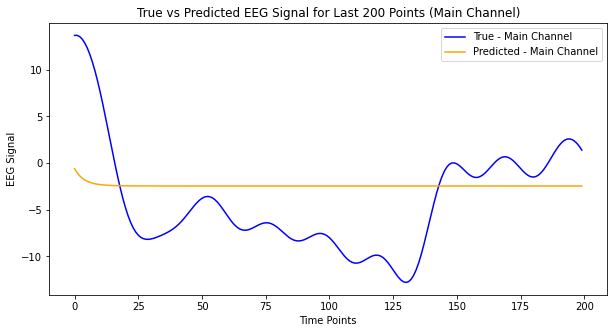

In [21]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, RepeatVector, TimeDistributed, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from scipy.signal import welch
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 主通道为第一个通道，辅助通道选择第2到第5个通道
main_channel = matrix_data[0, :]      # 主通道
aux_channels = matrix_data[1:5, :]    # 选择4个辅助通道

# 使用前4800个点作为训练，预测最后200个点
train_main = main_channel[:4800].reshape(1, 4800, 1)
test_main = main_channel[4800:].reshape(1, 200, 1)
train_aux = aux_channels[:, :4800].transpose((1, 0)).reshape(1, 4800, 4)  # 4个辅助通道
test_aux = aux_channels[:, 4800:].transpose((1, 0)).reshape(1, 200, 4)

# 定义包含卷积层和多层GRU的模型
def build_improved_gru_cnn_model():
    # 主通道输入
    main_input = Input(shape=(None, 1), name="main_input")  # None 表示任意长度输入
    # 辅助通道输入
    aux_input = Input(shape=(None, 4), name="aux_input")

    # 主通道卷积特征提取
    main_conv = Conv1D(32, kernel_size=3, activation='relu')(main_input)
    main_gru = GRU(64, return_sequences=True)(main_conv)
    main_gru = GRU(64, return_sequences=False)(main_gru)  # 多层GRU，输出为固定长度的特征向量

    # 辅助通道卷积特征提取
    aux_conv = Conv1D(32, kernel_size=3, activation='relu')(aux_input)
    aux_gru = GRU(64, return_sequences=True)(aux_conv)
    aux_gru = GRU(64, return_sequences=False)(aux_gru)  # 多层GRU，输出为固定长度的特征向量

    # 合并主通道和辅助通道的编码结果
    merged = Concatenate()([main_gru, aux_gru])

    # 重复编码结果200次，以便用于解码
    repeated_context = RepeatVector(200)(merged)

    # 解码器GRU用于预测未来200个时间步
    decoder_gru = GRU(64, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(1))(decoder_gru)  # 输出未来200步的预测序列

    # 构建模型
    model = Model(inputs=[main_input, aux_input], outputs=output)
    return model

# 初始化和编译模型
model = build_improved_gru_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit([train_main, train_aux], test_main.reshape(1, 200, 1), epochs=20, batch_size=1, verbose=1)

# 预测测试集未来200个时间步
predicted_y = model.predict([test_main, test_aux])

# 计算频谱相似度
def calculate_spectral_similarity(true_signal, predicted_signal):
    f_true, Pxx_true = welch(true_signal, nperseg=50)
    f_pred, Pxx_pred = welch(predicted_signal, nperseg=50)
    
    # 检查 Pxx_true 和 Pxx_pred 是否全为零
    if np.all(Pxx_true == 0) or np.all(Pxx_pred == 0):
        return np.nan
    
    # 计算余弦相似度
    similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
    return similarity

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(test_main.flatten(), predicted_y.flatten())
print("Spectral Similarity:", spectral_similarity)

# 打印均方误差
print("Mean Squared Error:", mean_squared_error(test_main.flatten(), predicted_y.flatten()))

# 绘制预测值与真实值
plt.figure(figsize=(10, 5))
plt.plot(test_main.flatten(), label="True - Main Channel", color="blue")
plt.plot(predicted_y.flatten(), label="Predicted - Main Channel", color="orange")
plt.xlabel("Time Points")
plt.ylabel("EEG Signal")
plt.title("True vs Predicted EEG Signal for Last 200 Points (Main Channel)")
plt.legend()
plt.show()


Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 49.0957 - mean_absolute_error: 5.8537
Epoch 2/20
1/1 [==============================] - 4s 4s/step - loss: 40.1501 - mean_absolute_error: 5.2421
Epoch 3/20
1/1 [==============================] - 5s 5s/step - loss: 34.6301 - mean_absolute_error: 4.9135
Epoch 4/20
1/1 [==============================] - 5s 5s/step - loss: 31.9299 - mean_absolute_error: 4.6586
Epoch 5/20
1/1 [==============================] - 5s 5s/step - loss: 31.1960 - mean_absolute_error: 4.5019
Epoch 6/20
1/1 [==============================] - 5s 5s/step - loss: 31.5135 - mean_absolute_error: 4.4277
Epoch 7/20
1/1 [==============================] - 5s 5s/step - loss: 32.0364 - mean_absolute_error: 4.3936
Epoch 8/20
1/1 [==============================] - 5s 5s/step - loss: 32.2639 - mean_absolute_error: 4.3792
Epoch 9/20
1/1 [==============================] - 5s 5s/step - loss: 32.0972 - mean_absolute_error: 4.3735
Epoch 10/20
1/1 [====================

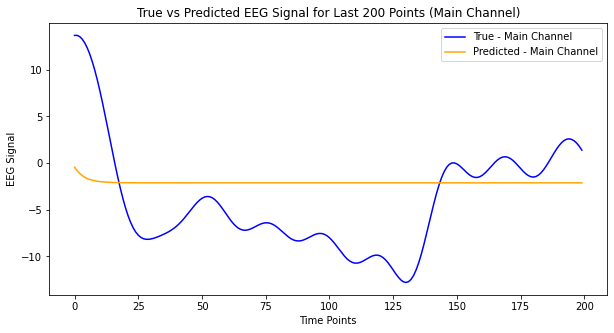

In [22]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, RepeatVector, TimeDistributed, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from scipy.signal import welch
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :5000]  # 取前5000个数据点

# 主通道为第一个通道，辅助通道选择第2到第5个通道
main_channel = matrix_data[0, :]      # 主通道
aux_channels = matrix_data[1:5, :]    # 选择4个辅助通道

# 使用前4800个点作为训练，预测最后200个点
train_main = main_channel[:4800].reshape(1, 4800, 1)
test_main = main_channel[4800:].reshape(1, 200, 1)
train_aux = aux_channels[:, :4800].transpose((1, 0)).reshape(1, 4800, 4)  # 4个辅助通道
test_aux = aux_channels[:, 4800:].transpose((1, 0)).reshape(1, 200, 4)

# 定义包含卷积层和多层GRU的模型
def build_improved_gru_cnn_model():
    # 主通道输入
    main_input = Input(shape=(None, 1), name="main_input")  # None 表示任意长度输入
    # 辅助通道输入
    aux_input = Input(shape=(None, 4), name="aux_input")

    # 主通道卷积特征提取
    main_conv = Conv1D(32, kernel_size=3, activation='relu')(main_input)
    main_gru = GRU(64, return_sequences=True)(main_conv)
    main_gru = GRU(64, return_sequences=False)(main_gru)  # 多层GRU，输出为固定长度的特征向量

    # 辅助通道卷积特征提取
    aux_conv = Conv1D(32, kernel_size=3, activation='relu')(aux_input)
    aux_gru = GRU(64, return_sequences=True)(aux_conv)
    aux_gru = GRU(64, return_sequences=False)(aux_gru)  # 多层GRU，输出为固定长度的特征向量

    # 合并主通道和辅助通道的编码结果
    merged = Concatenate()([main_gru, aux_gru])

    # 重复编码结果200次，以便用于解码
    repeated_context = RepeatVector(200)(merged)

    # 解码器GRU用于预测未来200个时间步
    decoder_gru = GRU(64, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(1))(decoder_gru)  # 输出未来200步的预测序列

    # 构建模型
    model = Model(inputs=[main_input, aux_input], outputs=output)
    return model

# 初始化和编译模型
model = build_improved_gru_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit([train_main, train_aux], test_main.reshape(1, 200, 1), epochs=20, batch_size=1, verbose=1)

# 预测测试集未来200个时间步
predicted_y = model.predict([test_main, test_aux])

# 计算频谱相似度
def calculate_spectral_similarity(true_signal, predicted_signal):
    f_true, Pxx_true = welch(true_signal, nperseg=50)
    f_pred, Pxx_pred = welch(predicted_signal, nperseg=50)
    
    # 检查 Pxx_true 和 Pxx_pred 是否全为零
    if np.all(Pxx_true == 0) or np.all(Pxx_pred == 0):
        return np.nan
    
    # 计算余弦相似度
    similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
    return similarity

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(test_main.flatten(), predicted_y.flatten())
print("Spectral Similarity:", spectral_similarity)

# 打印均方误差
print("Mean Squared Error:", mean_squared_error(test_main.flatten(), predicted_y.flatten()))

# 绘制预测值与真实值
plt.figure(figsize=(10, 5))
plt.plot(test_main.flatten(), label="True - Main Channel", color="blue")
plt.plot(predicted_y.flatten(), label="Predicted - Main Channel", color="orange")
plt.xlabel("Time Points")
plt.ylabel("EEG Signal")
plt.title("True vs Predicted EEG Signal for Last 200 Points (Main Channel)")
plt.legend()
plt.show()


Epoch 1/20
1/1 [==============================] - 9s 9s/step - loss: 62.2612 - mean_absolute_error: 6.5226
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 62.9270 - mean_absolute_error: 6.4480
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 62.2908 - mean_absolute_error: 6.4794
Epoch 4/20
1/1 [==============================] - 6s 6s/step - loss: 62.3087 - mean_absolute_error: 6.5338
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 62.5013 - mean_absolute_error: 6.5608
Epoch 6/20
1/1 [==============================] - 6s 6s/step - loss: 62.4335 - mean_absolute_error: 6.5528
Epoch 7/20
1/1 [==============================] - 6s 6s/step - loss: 62.2824 - mean_absolute_error: 6.5295
Epoch 8/20
1/1 [==============================] - 5s 5s/step - loss: 62.2119 - mean_absolute_error: 6.5057
Epoch 9/20
1/1 [==============================] - 6s 6s/step - loss: 62.2391 - mean_absolute_error: 6.4864
Epoch 10/20
1/1 [====================

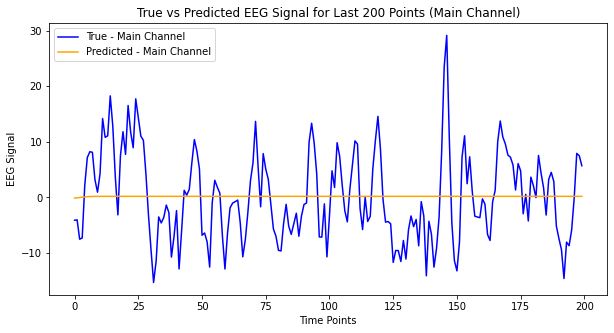

In [23]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, RepeatVector, TimeDistributed, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from scipy.signal import welch
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data'][:, :50000]  # 取前50000个数据点

# 每隔10个点采样一个
sampled_data = matrix_data[:, ::10]  # 结果为(16, 5000)

# 主通道为第一个通道，辅助通道选择第2到第5个通道
main_channel = sampled_data[0, :]      # 主通道
aux_channels = sampled_data[1:5, :]    # 选择4个辅助通道

# 使用前4800个点作为训练，预测最后200个点
train_main = main_channel[:4800].reshape(1, 4800, 1)
test_main = main_channel[4800:].reshape(1, 200, 1)
train_aux = aux_channels[:, :4800].transpose((1, 0)).reshape(1, 4800, 4)  # 4个辅助通道
test_aux = aux_channels[:, 4800:].transpose((1, 0)).reshape(1, 200, 4)

# 定义包含卷积层和多层GRU的模型
def build_improved_gru_cnn_model():
    # 主通道输入
    main_input = Input(shape=(None, 1), name="main_input")  # None 表示任意长度输入
    # 辅助通道输入
    aux_input = Input(shape=(None, 4), name="aux_input")

    # 主通道卷积特征提取
    main_conv = Conv1D(32, kernel_size=3, activation='relu')(main_input)
    main_gru = GRU(64, return_sequences=True)(main_conv)
    main_gru = GRU(64, return_sequences=False)(main_gru)  # 多层GRU，输出为固定长度的特征向量

    # 辅助通道卷积特征提取
    aux_conv = Conv1D(32, kernel_size=3, activation='relu')(aux_input)
    aux_gru = GRU(64, return_sequences=True)(aux_conv)
    aux_gru = GRU(64, return_sequences=False)(aux_gru)  # 多层GRU，输出为固定长度的特征向量

    # 合并主通道和辅助通道的编码结果
    merged = Concatenate()([main_gru, aux_gru])

    # 重复编码结果200次，以便用于解码
    repeated_context = RepeatVector(200)(merged)

    # 解码器GRU用于预测未来200个时间步
    decoder_gru = GRU(64, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(1))(decoder_gru)  # 输出未来200步的预测序列

    # 构建模型
    model = Model(inputs=[main_input, aux_input], outputs=output)
    return model

# 初始化和编译模型
model = build_improved_gru_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# 训练模型
model.fit([train_main, train_aux], test_main.reshape(1, 200, 1), epochs=20, batch_size=1, verbose=1)

# 预测测试集未来200个时间步
predicted_y = model.predict([test_main, test_aux])

# 计算频谱相似度
def calculate_spectral_similarity(true_signal, predicted_signal):
    f_true, Pxx_true = welch(true_signal, nperseg=50)
    f_pred, Pxx_pred = welch(predicted_signal, nperseg=50)
    
    # 检查 Pxx_true 和 Pxx_pred 是否全为零
    if np.all(Pxx_true == 0) or np.all(Pxx_pred == 0):
        return np.nan
    
    # 计算余弦相似度
    similarity = np.dot(Pxx_true, Pxx_pred) / (np.linalg.norm(Pxx_true) * np.linalg.norm(Pxx_pred))
    return similarity

# 计算和打印频谱相似度
spectral_similarity = calculate_spectral_similarity(test_main.flatten(), predicted_y.flatten())
print("Spectral Similarity:", spectral_similarity)

# 打印均方误差
print("Mean Squared Error:", mean_squared_error(test_main.flatten(), predicted_y.flatten()))

# 绘制预测值与真实值
plt.figure(figsize=(10, 5))
plt.plot(test_main.flatten(), label="True - Main Channel", color="blue")
plt.plot(predicted_y.flatten(), label="Predicted - Main Channel", color="orange")
plt.xlabel("Time Points")
plt.ylabel("EEG Signal")
plt.title("True vs Predicted EEG Signal for Last 200 Points (Main Channel)")
plt.legend()
plt.show()


In [25]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 在这里我们假设 `matrix_data` 已经加载，并且我们只采样 50000 个点中的每 10 个点
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 90  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并

    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
148/148 [==============================] - 18s 108ms/step - loss: 1.1141
Epoch 2/200
148/148 [==============================] - 19s 127ms/step - loss: 0.7958
Epoch 3/200
148/148 [==============================] - 19s 126ms/step - loss: 0.6982
Epoch 4/200
148/148 [==============================] - 19s 127ms/step - loss: 0.6374
Epoch 5/200
148/148 [==============================] - 19s 126ms/step - loss: 0.6046
Epoch 6/200
148/148 [==============================] - 19s 131ms/step - loss: 0.5591
Epoch 7/200
148/148 [==============================] - 19s 126ms/step - loss: 0.5579
Epoch 8/200
148/148 [==============================] - 19s 126ms/step - loss: 0.5329
Epoch 9/200
148/148 [==============================] - 19s 127ms/step - loss: 0.5101
Epoch 10/200
148/148 [==============================] - 19s 127ms/step - loss: 0.5037
Epoch 11/200
148/148 [==============================] - 19s 126ms/step - loss: 0.4786
Epoch 12/200
148/148 [==============================] - 19s 126

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 5 and the array at index 1 has size 1

Epoch 1/200
148/148 [==============================] - 18s 102ms/step - loss: 1.1141
Epoch 2/200
148/148 [==============================] - 18s 124ms/step - loss: 0.7958
Epoch 3/200
148/148 [==============================] - 18s 121ms/step - loss: 0.6982
Epoch 4/200
148/148 [==============================] - 19s 126ms/step - loss: 0.6374
Epoch 5/200
148/148 [==============================] - 19s 129ms/step - loss: 0.6046
Epoch 6/200
148/148 [==============================] - 18s 121ms/step - loss: 0.5591
Epoch 7/200
148/148 [==============================] - 19s 131ms/step - loss: 0.5579
Epoch 8/200
148/148 [==============================] - 18s 123ms/step - loss: 0.5329
Epoch 9/200
148/148 [==============================] - 18s 124ms/step - loss: 0.5101
Epoch 10/200
148/148 [==============================] - 18s 121ms/step - loss: 0.5037
Epoch 11/200
148/148 [==============================] - 18s 123ms/step - loss: 0.4786
Epoch 12/200
148/148 [==============================] - 18s 121

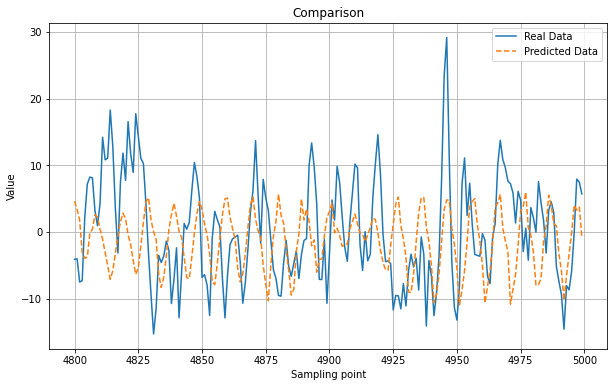

频谱相似度: 0.5086


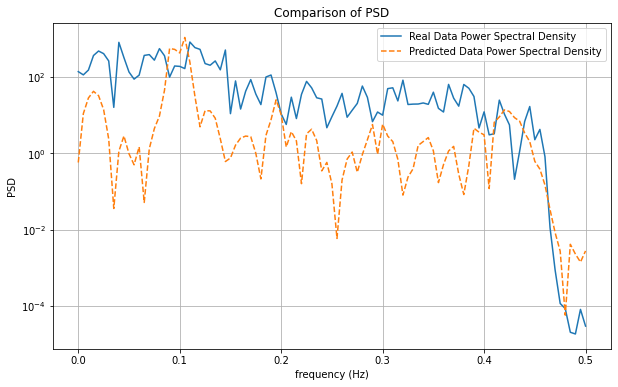

功率谱密度 (PSD) 相似度: 0.2491


In [26]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 90  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
148/148 [==============================] - 23s 135ms/step - loss: 1.1696
Epoch 2/200
148/148 [==============================] - 20s 133ms/step - loss: 0.9216
Epoch 3/200
148/148 [==============================] - 22s 146ms/step - loss: 0.8502
Epoch 4/200
148/148 [==============================] - 21s 142ms/step - loss: 0.7948
Epoch 5/200
148/148 [==============================] - 20s 135ms/step - loss: 0.7319
Epoch 6/200
148/148 [==============================] - 19s 132ms/step - loss: 0.6971
Epoch 7/200
148/148 [==============================] - 20s 132ms/step - loss: 0.6622
Epoch 8/200
148/148 [==============================] - 20s 136ms/step - loss: 0.6396
Epoch 9/200
148/148 [==============================] - 21s 140ms/step - loss: 0.6145
Epoch 10/200
148/148 [==============================] - 22s 145ms/step - loss: 0.6012
Epoch 11/200
148/148 [==============================] - 19s 130ms/step - loss: 0.5894
Epoch 12/200
148/148 [==============================] - 20s 133

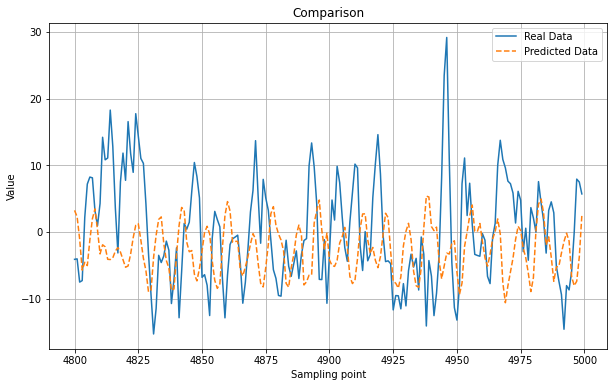

频谱相似度: 0.5314


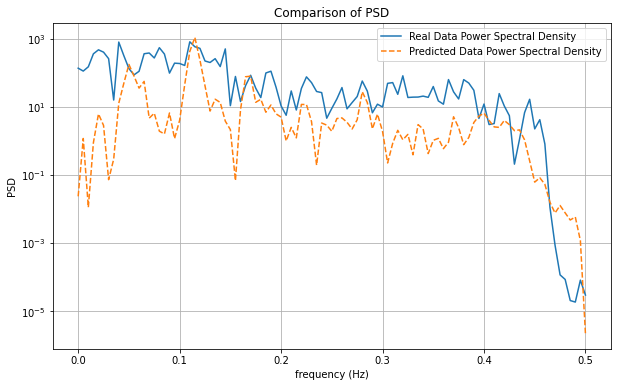

功率谱密度 (PSD) 相似度: 0.5019


In [27]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 90  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return 0.5* mse_loss +  spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 15s 160ms/step - loss: 1.1527
Epoch 2/200
75/75 [==============================] - 12s 161ms/step - loss: 0.9024
Epoch 3/200
75/75 [==============================] - 12s 159ms/step - loss: 0.7976
Epoch 4/200
75/75 [==============================] - 12s 159ms/step - loss: 0.7381
Epoch 5/200
75/75 [==============================] - 12s 159ms/step - loss: 0.7087
Epoch 6/200
75/75 [==============================] - 12s 159ms/step - loss: 0.6779
Epoch 7/200
75/75 [==============================] - 12s 161ms/step - loss: 0.6728
Epoch 8/200
75/75 [==============================] - 12s 160ms/step - loss: 0.6207
Epoch 9/200
75/75 [==============================] - 12s 159ms/step - loss: 0.6041
Epoch 10/200
75/75 [==============================] - 12s 160ms/step - loss: 0.6097
Epoch 11/200
75/75 [==============================] - 12s 159ms/step - loss: 0.5827
Epoch 12/200
75/75 [==============================] - 12s 161ms/step - loss: 0.5705
E

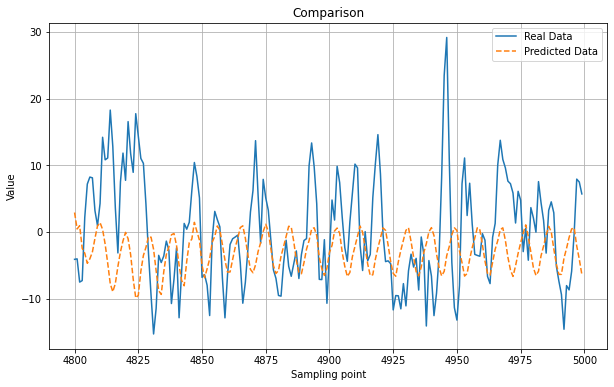

频谱相似度: 0.4121


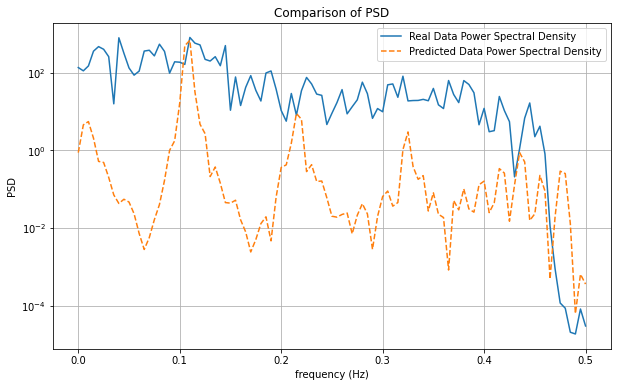

功率谱密度 (PSD) 相似度: 0.3895


In [28]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return 0.5* mse_loss +  spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
73/73 [==============================] - 41s 532ms/step - loss: 1.1690
Epoch 2/200
73/73 [==============================] - 41s 566ms/step - loss: 0.9095
Epoch 3/200
73/73 [==============================] - 42s 570ms/step - loss: 0.8161
Epoch 4/200
73/73 [==============================] - 41s 568ms/step - loss: 0.7354
Epoch 5/200
73/73 [==============================] - 42s 569ms/step - loss: 0.7005
Epoch 6/200
73/73 [==============================] - 41s 564ms/step - loss: 0.6858
Epoch 7/200
73/73 [==============================] - 41s 564ms/step - loss: 0.6454
Epoch 8/200
73/73 [==============================] - 41s 565ms/step - loss: 0.6148
Epoch 9/200
73/73 [==============================] - 41s 566ms/step - loss: 0.6122
Epoch 10/200
73/73 [==============================] - 41s 567ms/step - loss: 0.5843
Epoch 11/200
73/73 [==============================] - 41s 562ms/step - loss: 0.5778
Epoch 12/200
73/73 [==============================] - 41s 565ms/step - loss: 0.5741
E

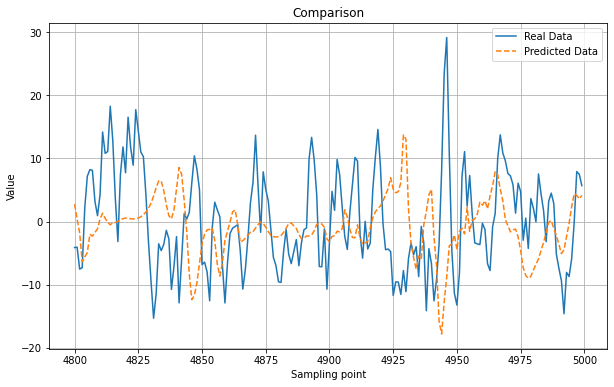

频谱相似度: 0.7575


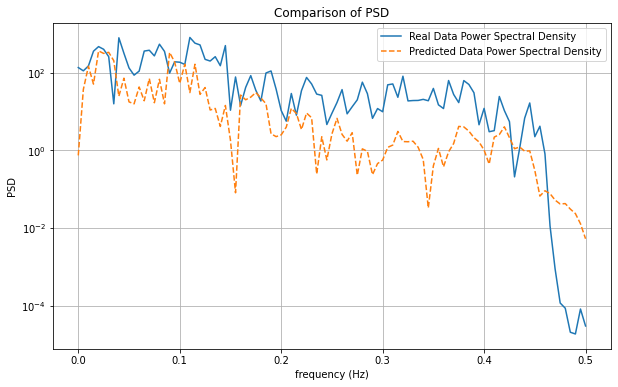

功率谱密度 (PSD) 相似度: 0.5184


In [29]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 150  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return 0.5* mse_loss +  spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
72/72 [==============================] - 31s 395ms/step - loss: 1.1168
Epoch 2/200
72/72 [==============================] - 30s 418ms/step - loss: 0.8984
Epoch 3/200
72/72 [==============================] - 30s 422ms/step - loss: 0.8005
Epoch 4/200
72/72 [==============================] - 31s 429ms/step - loss: 0.7577
Epoch 5/200
72/72 [==============================] - 31s 431ms/step - loss: 0.7094
Epoch 6/200
72/72 [==============================] - 31s 431ms/step - loss: 0.6579
Epoch 7/200
72/72 [==============================] - 31s 431ms/step - loss: 0.6507
Epoch 8/200
72/72 [==============================] - 31s 434ms/step - loss: 0.6360
Epoch 9/200
72/72 [==============================] - 32s 438ms/step - loss: 0.6166
Epoch 10/200
72/72 [==============================] - 31s 433ms/step - loss: 0.5884
Epoch 11/200
72/72 [==============================] - 31s 428ms/step - loss: 0.5862
Epoch 12/200
72/72 [==============================] - 31s 429ms/step - loss: 0.5684
E

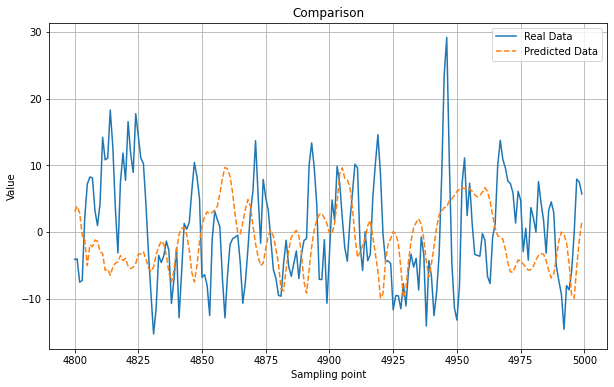

频谱相似度: 0.7432


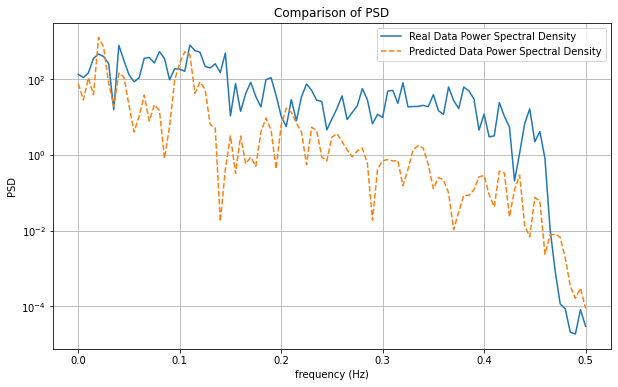

功率谱密度 (PSD) 相似度: 0.5194


In [2]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 200  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return 0.5* mse_loss +  spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


In [3]:
import scipy.io as scio
import matplotlib.pyplot as plt

data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')

matrix_data = data['data']

print(f"\nType of 'data':", type(matrix_data))
print(f"Shape of 'data':", matrix_data.shape)


Type of 'data': <class 'numpy.ndarray'>
Shape of 'data': (16, 604700)


In [4]:
matrix_data

array([[ 4.444756  ,  4.384025  ,  4.394761  , ..., -1.6975831 ,
        -1.5359678 , -1.4593594 ],
       [ 4.153684  ,  4.6202216 ,  5.008066  , ...,  6.456798  ,
         6.6081414 ,  6.685831  ],
       [ 0.7505848 ,  0.9101647 ,  1.0704209 , ...,  2.336522  ,
         2.4247794 ,  2.4696019 ],
       ...,
       [-0.32545736, -0.17869255, -0.10094681, ...,  1.5460287 ,
         2.1034224 ,  2.5912766 ],
       [ 4.4142976 ,  4.5325975 ,  4.6303506 , ...,  1.6850107 ,
         1.8536906 ,  1.9826005 ],
       [ 4.7812133 ,  4.8481007 ,  4.9546366 , ..., -0.6113241 ,
        -0.47615322, -0.4126569 ]], dtype=float32)

Epoch 1/200
75/75 [==============================] - 12s 109ms/step - loss: 1.1723
Epoch 2/200
75/75 [==============================] - 8s 108ms/step - loss: 0.9042
Epoch 3/200
75/75 [==============================] - 8s 109ms/step - loss: 0.8117
Epoch 4/200
75/75 [==============================] - 8s 107ms/step - loss: 0.7553
Epoch 5/200
75/75 [==============================] - 8s 106ms/step - loss: 0.7047
Epoch 6/200
75/75 [==============================] - 8s 107ms/step - loss: 0.6438
Epoch 7/200
75/75 [==============================] - 8s 105ms/step - loss: 0.6167
Epoch 8/200
75/75 [==============================] - 8s 105ms/step - loss: 0.5989
Epoch 9/200
75/75 [==============================] - 8s 105ms/step - loss: 0.5731
Epoch 10/200
75/75 [==============================] - 8s 105ms/step - loss: 0.5617
Epoch 11/200
75/75 [==============================] - 8s 104ms/step - loss: 0.5351
Epoch 12/200
75/75 [==============================] - 8s 106ms/step - loss: 0.5349
Epoch 13/200

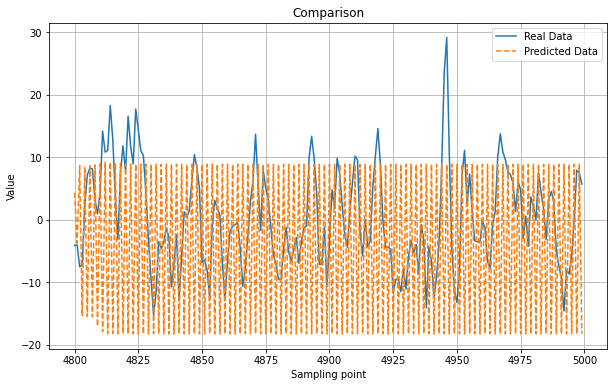

频谱相似度: 0.0625


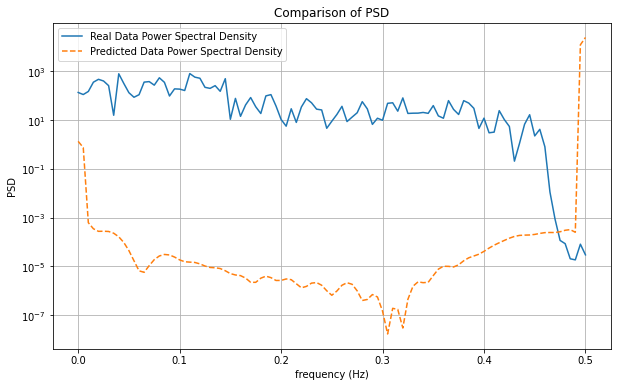

功率谱密度 (PSD) 相似度: 0.0000


In [5]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:10, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return 0.5* mse_loss +  spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 11s 111ms/step - loss: 1.0877
Epoch 2/200
75/75 [==============================] - 8s 111ms/step - loss: 0.7672
Epoch 3/200
75/75 [==============================] - 8s 111ms/step - loss: 0.6620
Epoch 4/200
75/75 [==============================] - 9s 113ms/step - loss: 0.6053
Epoch 5/200
75/75 [==============================] - 8s 113ms/step - loss: 0.5518
Epoch 6/200
75/75 [==============================] - 8s 112ms/step - loss: 0.5340
Epoch 7/200
75/75 [==============================] - 8s 112ms/step - loss: 0.5104
Epoch 8/200
75/75 [==============================] - 8s 113ms/step - loss: 0.4884
Epoch 9/200
75/75 [==============================] - 8s 112ms/step - loss: 0.4741
Epoch 10/200
75/75 [==============================] - 8s 112ms/step - loss: 0.4618
Epoch 11/200
75/75 [==============================] - 8s 111ms/step - loss: 0.4353
Epoch 12/200
75/75 [==============================] - 8s 111ms/step - loss: 0.4314
Epoch 13/200

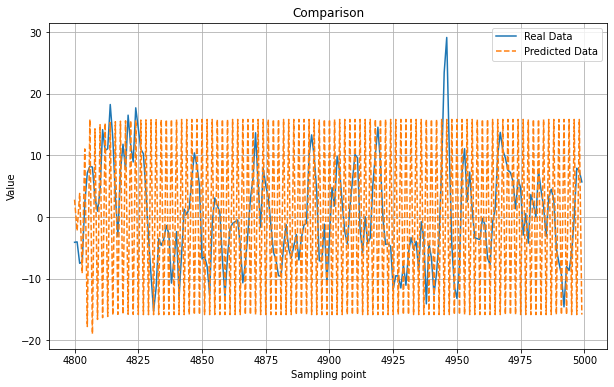

频谱相似度: 0.0444


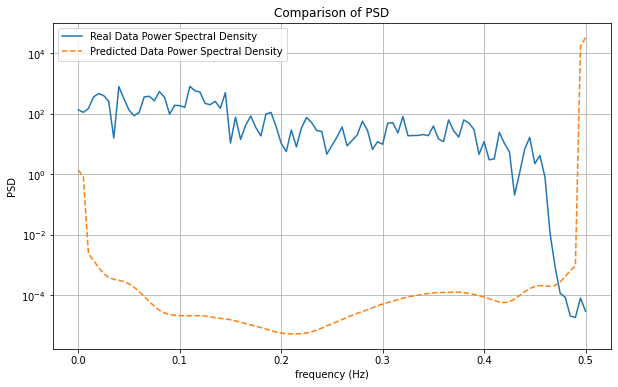

功率谱密度 (PSD) 相似度: 0.0000


In [6]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:10, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 13s 124ms/step - loss: 1.0461
Epoch 2/200
75/75 [==============================] - 9s 121ms/step - loss: 0.7409
Epoch 3/200
75/75 [==============================] - 9s 117ms/step - loss: 0.6408
Epoch 4/200
75/75 [==============================] - 9s 123ms/step - loss: 0.6128
Epoch 5/200
75/75 [==============================] - 9s 121ms/step - loss: 0.5665
Epoch 6/200
75/75 [==============================] - 9s 117ms/step - loss: 0.5421
Epoch 7/200
75/75 [==============================] - 9s 119ms/step - loss: 0.5251
Epoch 8/200
75/75 [==============================] - 9s 119ms/step - loss: 0.5086
Epoch 9/200
75/75 [==============================] - 9s 118ms/step - loss: 0.4927
Epoch 10/200
75/75 [==============================] - 9s 117ms/step - loss: 0.4893
Epoch 11/200
75/75 [==============================] - 9s 119ms/step - loss: 0.4711
Epoch 12/200
75/75 [==============================] - 9s 117ms/step - loss: 0.4575
Epoch 13/200

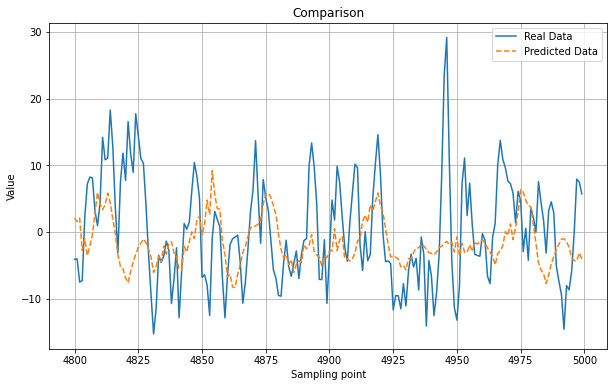

频谱相似度: 0.7191


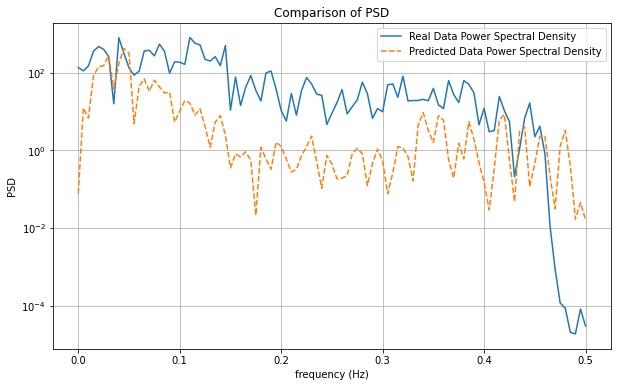

功率谱密度 (PSD) 相似度: 0.5005


In [7]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 14s 144ms/step - loss: 1.0820
Epoch 2/200
75/75 [==============================] - 10s 139ms/step - loss: 0.7563
Epoch 3/200
75/75 [==============================] - 11s 140ms/step - loss: 0.6615
Epoch 4/200
75/75 [==============================] - 10s 137ms/step - loss: 0.6273
Epoch 5/200
75/75 [==============================] - 11s 140ms/step - loss: 0.5795
Epoch 6/200
75/75 [==============================] - 11s 140ms/step - loss: 0.5497
Epoch 7/200
75/75 [==============================] - 10s 139ms/step - loss: 0.5314
Epoch 8/200
75/75 [==============================] - 11s 141ms/step - loss: 0.4985
Epoch 9/200
75/75 [==============================] - 10s 139ms/step - loss: 0.4843
Epoch 10/200
75/75 [==============================] - 10s 138ms/step - loss: 0.4708
Epoch 11/200
75/75 [==============================] - 11s 144ms/step - loss: 0.4485
Epoch 12/200
75/75 [==============================] - 11s 149ms/step - loss: 0.4413
E

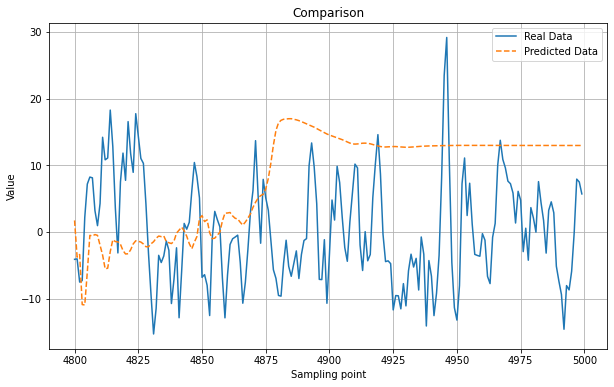

频谱相似度: 0.3662


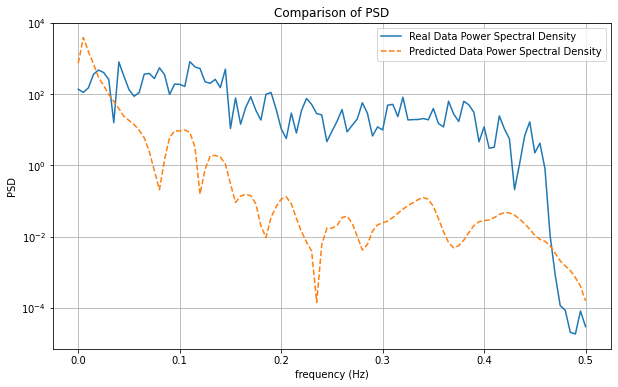

功率谱密度 (PSD) 相似度: 0.1513


In [8]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:7, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 15s 123ms/step - loss: 0.9484
Epoch 2/200
75/75 [==============================] - 9s 113ms/step - loss: 0.6675
Epoch 3/200
75/75 [==============================] - 8s 113ms/step - loss: 0.6104
Epoch 4/200
75/75 [==============================] - 9s 120ms/step - loss: 0.5854
Epoch 5/200
75/75 [==============================] - 8s 107ms/step - loss: 0.5660
Epoch 6/200
75/75 [==============================] - 7s 99ms/step - loss: 0.5479
Epoch 7/200
75/75 [==============================] - 8s 101ms/step - loss: 0.5235
Epoch 8/200
75/75 [==============================] - 8s 108ms/step - loss: 0.5143
Epoch 9/200
75/75 [==============================] - 8s 109ms/step - loss: 0.5065
Epoch 10/200
75/75 [==============================] - 9s 120ms/step - loss: 0.5007
Epoch 11/200
75/75 [==============================] - 8s 113ms/step - loss: 0.4920
Epoch 12/200
75/75 [==============================] - 8s 107ms/step - loss: 0.4761
Epoch 13/200


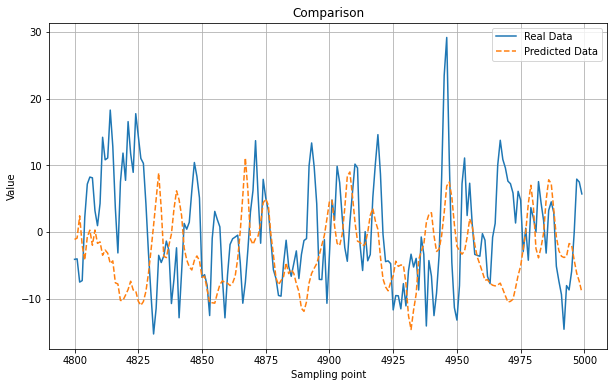

频谱相似度: 0.6024


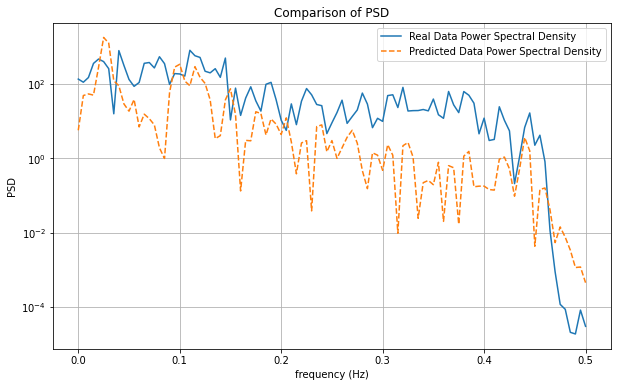

功率谱密度 (PSD) 相似度: 0.3972


In [2]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:3, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 11s 109ms/step - loss: 1.0589
Epoch 2/200
75/75 [==============================] - 8s 111ms/step - loss: 0.7522
Epoch 3/200
75/75 [==============================] - 8s 110ms/step - loss: 0.6532
Epoch 4/200
75/75 [==============================] - 8s 112ms/step - loss: 0.6164
Epoch 5/200
75/75 [==============================] - 8s 108ms/step - loss: 0.5754
Epoch 6/200
75/75 [==============================] - 8s 109ms/step - loss: 0.5412
Epoch 7/200
75/75 [==============================] - 8s 112ms/step - loss: 0.5296
Epoch 8/200
75/75 [==============================] - 8s 109ms/step - loss: 0.4989
Epoch 9/200
75/75 [==============================] - 8s 108ms/step - loss: 0.4976
Epoch 10/200
75/75 [==============================] - 8s 108ms/step - loss: 0.4896
Epoch 11/200
75/75 [==============================] - 8s 110ms/step - loss: 0.4665
Epoch 12/200
75/75 [==============================] - 8s 108ms/step - loss: 0.4551
Epoch 13/200

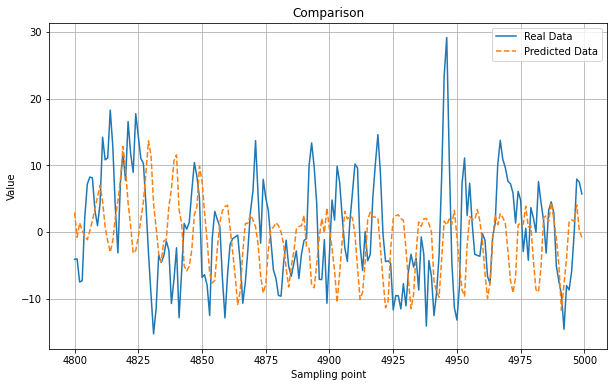

频谱相似度: 0.5333


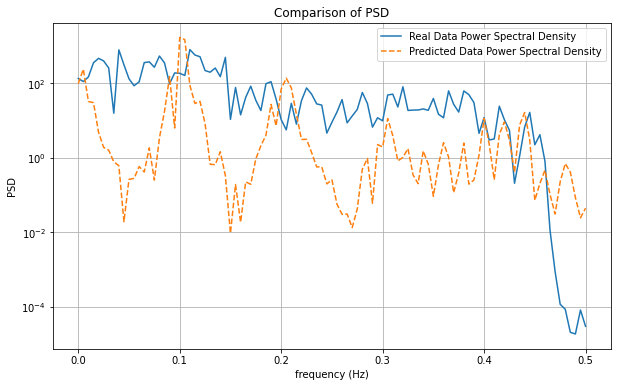

功率谱密度 (PSD) 相似度: 0.1655


In [3]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:6, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 12s 113ms/step - loss: 1.0001
Epoch 2/200
75/75 [==============================] - 9s 114ms/step - loss: 0.7235
Epoch 3/200
75/75 [==============================] - 8s 111ms/step - loss: 0.6308
Epoch 4/200
75/75 [==============================] - 8s 113ms/step - loss: 0.6055
Epoch 5/200
75/75 [==============================] - 9s 113ms/step - loss: 0.5686
Epoch 6/200
75/75 [==============================] - 8s 112ms/step - loss: 0.5623
Epoch 7/200
75/75 [==============================] - 8s 112ms/step - loss: 0.5328
Epoch 8/200
75/75 [==============================] - 8s 112ms/step - loss: 0.5157
Epoch 9/200
75/75 [==============================] - 8s 113ms/step - loss: 0.5096
Epoch 10/200
75/75 [==============================] - 8s 112ms/step - loss: 0.4981
Epoch 11/200
75/75 [==============================] - 8s 112ms/step - loss: 0.4829
Epoch 12/200
75/75 [==============================] - 8s 112ms/step - loss: 0.4745
Epoch 13/200

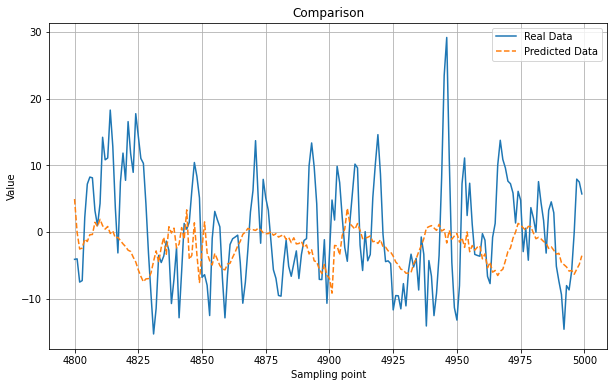

频谱相似度: 0.4983


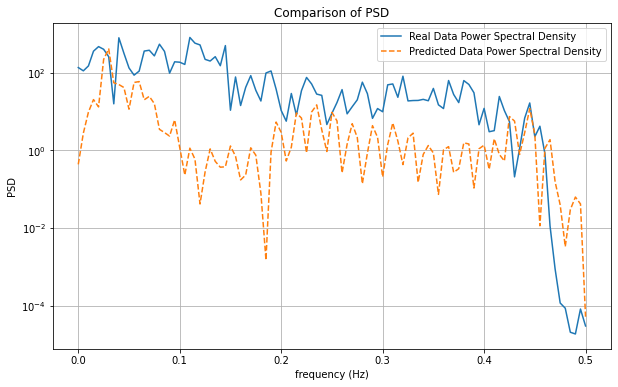

功率谱密度 (PSD) 相似度: 0.3149


In [4]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:4, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
75/75 [==============================] - 13s 136ms/step - loss: 0.8778
Epoch 2/200
75/75 [==============================] - 11s 140ms/step - loss: 0.6525
Epoch 3/200
75/75 [==============================] - 10s 131ms/step - loss: 0.5901
Epoch 4/200
75/75 [==============================] - 10s 133ms/step - loss: 0.5744
Epoch 5/200
75/75 [==============================] - 10s 134ms/step - loss: 0.5502
Epoch 6/200
75/75 [==============================] - 10s 131ms/step - loss: 0.5413
Epoch 7/200
75/75 [==============================] - 10s 132ms/step - loss: 0.5293
Epoch 8/200
75/75 [==============================] - 10s 137ms/step - loss: 0.5067
Epoch 9/200
75/75 [==============================] - 10s 135ms/step - loss: 0.5014
Epoch 10/200
75/75 [==============================] - 10s 132ms/step - loss: 0.5116
Epoch 11/200
75/75 [==============================] - 10s 134ms/step - loss: 0.4982
Epoch 12/200
75/75 [==============================] - 10s 135ms/step - loss: 0.4856
E

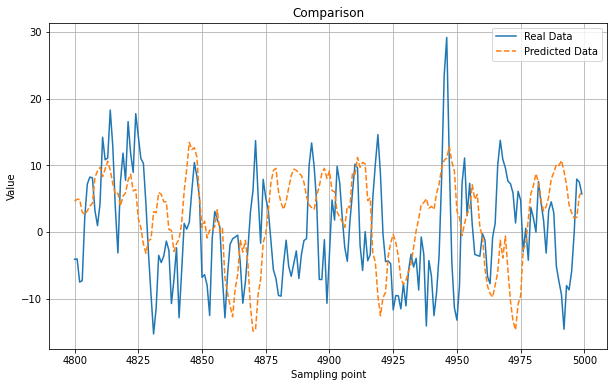

频谱相似度: 0.6908


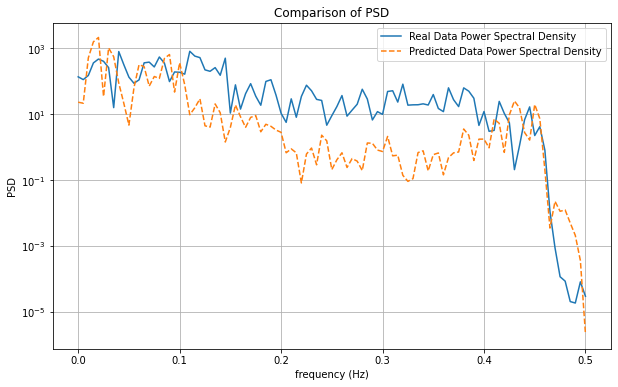

功率谱密度 (PSD) 相似度: 0.4248


In [5]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:2, :50000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:4800].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[4800:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:4800].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 50  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 200
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/150
749/749 [==============================] - 68s 88ms/step - loss: 0.6439
Epoch 2/150
749/749 [==============================] - 68s 90ms/step - loss: 0.4662
Epoch 3/150
749/749 [==============================] - 67s 90ms/step - loss: 0.3934
Epoch 4/150
749/749 [==============================] - 67s 89ms/step - loss: 0.3660
Epoch 5/150
749/749 [==============================] - 66s 89ms/step - loss: 0.3454
Epoch 6/150
749/749 [==============================] - 67s 89ms/step - loss: 0.3145
Epoch 7/150
749/749 [==============================] - 66s 88ms/step - loss: 0.2840
Epoch 8/150
749/749 [==============================] - 66s 88ms/step - loss: 0.2617
Epoch 9/150
749/749 [==============================] - 66s 89ms/step - loss: 0.2422
Epoch 10/150
749/749 [==============================] - 66s 88ms/step - loss: 0.2304
Epoch 11/150
749/749 [==============================] - 66s 88ms/step - loss: 0.2194
Epoch 12/150
749/749 [==============================] - 66s 88ms/step - lo

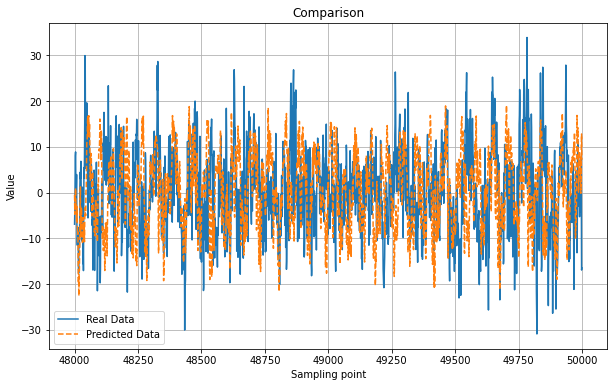

频谱相似度: 0.7120


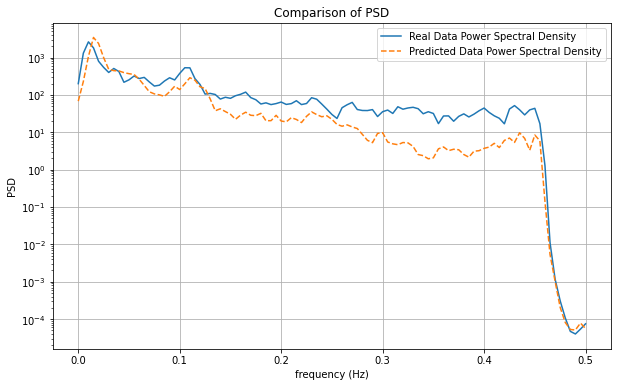

功率谱密度 (PSD) 相似度: 0.7507


In [3]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :500000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :500000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:48000].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[48000:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:48000].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 70  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 150
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(2000):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(48000, 50000), test_data_rescaled, label='Real Data')
plt.plot(range(48000, 50000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/150
151/151 [==============================] - 25s 148ms/step - loss: 0.8903
Epoch 2/150
151/151 [==============================] - 28s 185ms/step - loss: 0.6162
Epoch 3/150
151/151 [==============================] - 29s 191ms/step - loss: 0.5576
Epoch 4/150
151/151 [==============================] - 25s 165ms/step - loss: 0.5192
Epoch 5/150
151/151 [==============================] - 25s 162ms/step - loss: 0.4954
Epoch 6/150
151/151 [==============================] - 24s 162ms/step - loss: 0.4817
Epoch 7/150
151/151 [==============================] - 25s 165ms/step - loss: 0.4626
Epoch 8/150
151/151 [==============================] - 24s 159ms/step - loss: 0.4546
Epoch 9/150
151/151 [==============================] - 24s 161ms/step - loss: 0.4352
Epoch 10/150
151/151 [==============================] - 25s 164ms/step - loss: 0.3955
Epoch 11/150
151/151 [==============================] - 26s 174ms/step - loss: 0.3773
Epoch 12/150
151/151 [==============================] - 26s 170

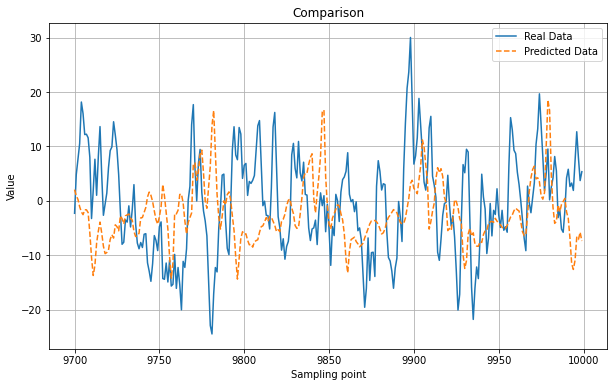

频谱相似度: 0.6699


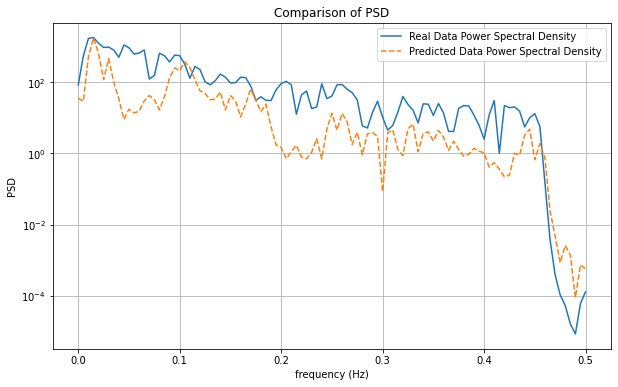

功率谱密度 (PSD) 相似度: 0.7322


In [4]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :100000:10]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :100000:10]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:9700].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[9700:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:48000].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 70  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 150
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(300):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(9700, 10000), test_data_rescaled, label='Real Data')
plt.plot(range(9700, 10000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/150
151/151 [==============================] - 25s 149ms/step - loss: 0.7968
Epoch 2/150
151/151 [==============================] - 24s 160ms/step - loss: 0.5281
Epoch 3/150
151/151 [==============================] - 27s 176ms/step - loss: 0.4202
Epoch 4/150
151/151 [==============================] - 26s 171ms/step - loss: 0.3401
Epoch 5/150
151/151 [==============================] - 25s 169ms/step - loss: 0.2675
Epoch 6/150
151/151 [==============================] - 25s 164ms/step - loss: 0.2197
Epoch 7/150
151/151 [==============================] - 24s 161ms/step - loss: 0.1796
Epoch 8/150
151/151 [==============================] - 24s 159ms/step - loss: 0.1602
Epoch 9/150
151/151 [==============================] - 24s 159ms/step - loss: 0.1418
Epoch 10/150
151/151 [==============================] - 24s 160ms/step - loss: 0.1279
Epoch 11/150
151/151 [==============================] - 24s 161ms/step - loss: 0.1223
Epoch 12/150
151/151 [==============================] - 24s 160

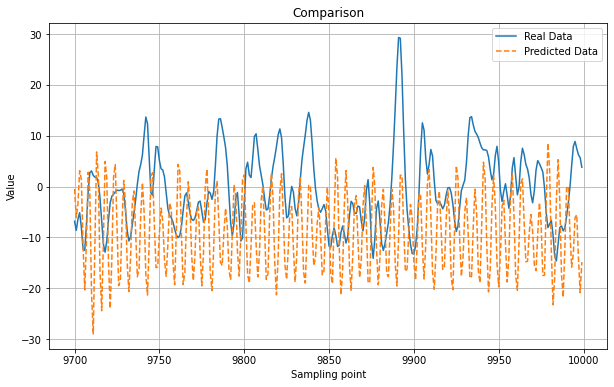

频谱相似度: 0.2716


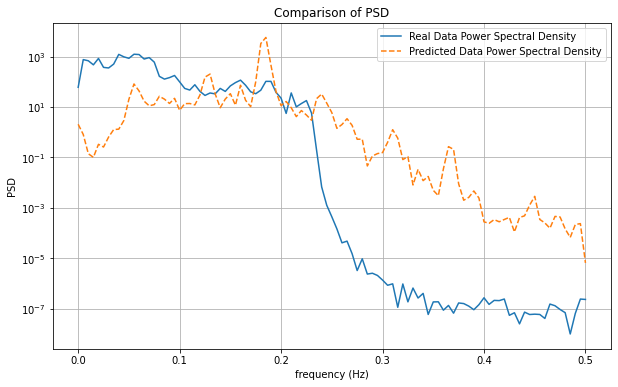

功率谱密度 (PSD) 相似度: 0.0487


In [5]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据加载与采样
# 假设 `matrix_data` 为原始数据，形状为 (通道数, 数据点数)
# 假设第一通道为主通道，其余通道为辅助通道

# 假设数据已加载为 `matrix_data`
# matrix_data.shape = (16, 50000)
main_channel = matrix_data[0, :50000:5]  # 主通道采样得到 5000 个点
aux_channels = matrix_data[1:5, :50000:5]  # 选择 4 个辅助通道并采样，得到 (4, 5000)

# 数据标准化
scaler = StandardScaler()
main_channel_scaled = scaler.fit_transform(main_channel[:9700].reshape(-1, 1)).reshape(-1)
test_main_scaled = scaler.transform(main_channel[9700:].reshape(-1, 1)).reshape(-1)

# 多通道数据标准化
aux_channels_scaled = []
for ch in aux_channels:
    aux_scaler = StandardScaler()
    aux_channel_scaled = aux_scaler.fit_transform(ch[:48000].reshape(-1, 1)).reshape(-1)
    aux_channels_scaled.append(aux_channel_scaled)

# 设置参数
n_steps = 70  # 时间步长
X, y = [], []

# 构建训练数据
for i in range(len(main_channel_scaled) - n_steps):
    X_main = main_channel_scaled[i:i+n_steps].reshape(n_steps, 1)  # 主通道数据
    X_aux = np.array([aux[i:i+n_steps] for aux in aux_channels_scaled]).T  # 辅助通道数据
    X.append(np.hstack([X_main, X_aux]))  # 将主通道与辅助通道合并
    y.append(main_channel_scaled[i + n_steps])  # 预测主通道的下一个点

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_multi_channel_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)
    x = GRU(units)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = K.mean(K.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return  mse_loss +  0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_multi_channel_gru_model((n_steps, 1 + len(aux_channels)), units=128, dropout=0.3)

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=custom_loss)

# 设置早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 训练模型
epochs = 150
model.fit(X, y, epochs=epochs, batch_size=64, shuffle=False, verbose=1, callbacks=[early_stopping])

# 预测未来 200 个点
X_input = X[-1].reshape(1, n_steps, 1 + len(aux_channels))
predicted_points = []

for _ in range(300):
    predicted = model.predict(X_input, verbose=0)

    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0

    predicted_points.append(predicted[0][0])

    # 调整 predicted_reshaped 的形状以匹配 X_input
    predicted_reshaped = np.array([predicted[0][0]] * (1 + len(aux_channels))).reshape(1, 1, 1 + len(aux_channels))
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_main_scaled.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(range(9700, 10000), test_data_rescaled, label='Real Data')
plt.plot(range(9700, 10000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
spectral_similarity = cosine_similarity(np.abs(fft_real).reshape(1, -1), np.abs(fft_pred).reshape(1, -1))[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算功率谱密度相似度 (余弦相似度)
psd_similarity = cosine_similarity(psd_real.reshape(1, -1), psd_pred.reshape(1, -1))[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')
